In [ ]:
# Configurations
DATASET = "data.xlsx"
DATASET_SHEET = "data"
QUESTION_DEFINITIONS = "question_definitions.xlsx"
QUESTION_DEFINITIONS_SHEET = "Sheet1"
ADDITIONAL_STOP_WORDS = ["nil"]
WORD_FREQUENCIES_TOP = 5
RESPONDENT = "Respondent"
EPV_HOSTING_COST = {
    "small": 1,
    "medium": 2,
    "large": 3
}

In [2]:
from operator import itemgetter
from IPython.core.display import display, HTML
import re
from pathlib import Path
import datetime

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import figure

# import nltk
# nltk.download(['stopwords','vader_lexicon'])
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# matplotlib Configurations
# params = {
#     'figure.figsize': (15, 5),
#     'font.size': 16
# }
# plt.rcParams.update(params)

def create_graph(x, y, title="", xlabel="", ylabel= "", type=""):
    fig, ax = plt.subplots()
    
    if type == "bar":
        ax.bar(x, y)
    else:
        ax.plot(x, y, "x-")
    
    ax.set_title(title, pad=50)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure that x-axis is an integer where applicable
    ax.yaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure that y-axis is an integer where applicable
    # Hide the top and right borders
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # Show the values on top of the point / bar
    for i, v in enumerate(y):
        ax.text(i, v + .05, str(v), ha='center', va='bottom')
    plt.show()
    
def html_print(text):
    display(HTML(text))
    
def generate_word_list(s):
    processed_wordlist = []
    # Convert string to lowercase
    s = s.lower()
    wordlist = s.split()
    for word in wordlist:
        # Avoid processing stop words
        if word not in stopWords and word not in ADDITIONAL_STOP_WORDS:
            # Remove symbols
            word = re.sub(r'[^\w]', " ", word)
            processed_words = word.split()
            for w in processed_words:
                # Not adding words with only one alphabet
                if len(w) > 1:
                    processed_wordlist.append(w)
    return processed_wordlist

def word_frequencies(wordlist):
    ps = PorterStemmer()
    wordfreq = []
    wordstems = []
    for w in wordlist:
        wordfreq.append(wordlist.count(w))
        wordstems.append(ps.stem(w))

    result = list(zip(wordlist, wordfreq, wordstems))
    # Remove duplicates
    result = list(dict.fromkeys(result))
    
    # Sort the list based on stems
    result = sorted(result, key=lambda x:x[2])
    # Group similar words based on stems
    previousStem = ""
    tpl = ("", 0)
    newResult = [(", ".join(m[0] for m in result if r[2] == m[2]), sum(k[1] for k in result if r[2] == k[2])) for r in result]
    newResult = list(set(newResult)) # remove duplicates
            
    # Sort the list
    newResult = sorted(newResult, key=lambda x:x[1], reverse=True)
    if len(newResult) > WORD_FREQUENCIES_TOP:
        return newResult[:WORD_FREQUENCIES_TOP]
    else:
        return newResult

def sort_tuples(t, reverse=True):
    return sorted(t, key=lambda k: k[1], reverse=reverse)

def word_frequency_graph(wf, graph_title):
    if len(wf) > 0:
        x, y = zip(*sort_tuples(wf))
        create_graph(x, y, graph_title, "Word", "Count", "bar")
        
def k_means_clustering(titles, documents):
    # Represent each document as a vector
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(documents)

    # Using elbow method to determine the number of clusters
    Sum_of_squared_distances = []
    K = range(2,10)
    best_cluster_no = 0 # Best cluster number which you will get
    previous_silh_avg = 0.0

    for k in K:
        km = KMeans(n_clusters=k, max_iter=200, n_init=10)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)

        # To determine the most optimal number of clusters automatically (without looking at the graph)
        cluster_labels = km.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > previous_silh_avg:
            previous_silh_avg = silhouette_avg
            best_cluster_no = k

    # create_graph(K, Sum_of_squared_distances,"Elbow Method For Optimal k", "k", "Sum of Squared Distances")
    print("Total Clusters: " + str(best_cluster_no))
    
    # Perform K-Means clustering
    model = KMeans(n_clusters=best_cluster_no, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)
    labels=model.labels_
    # cls=pd.DataFrame(list(zip(titles,labels)),columns=['title','cluster'])
    # print(cls.sort_values(by=['cluster']))
    return list(zip(titles,labels))

now = str(datetime.datetime.now()).split(" ")
folder_name = now[0] + "_" + now[1].split(".")[0].replace(":", "-")
if Path('results\\' + folder_name).is_dir() == False:
    Path('results\\' + folder_name).mkdir(parents=True, exist_ok=True)
def save_to_spreadsheet(data, question_no):
    s_df = pd.DataFrame(data=data)
    s_df.to_excel("results\\" + folder_name + "\Q" + str(question_no) + ".xlsx", sheet_name="Q" + str(question_no), index=False)
    print("Refer to 'results\\" + folder_name + "\Q" + str(question_no) + ".xlsx' for the processed data.")

Total Responses: 13


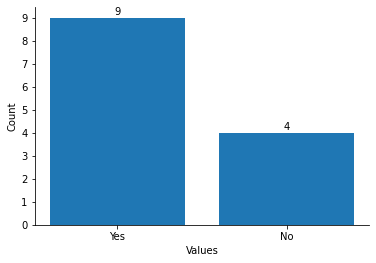

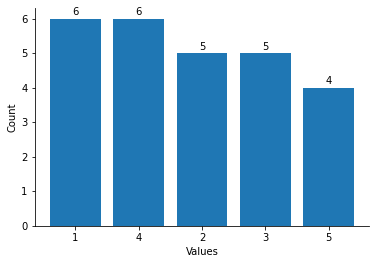

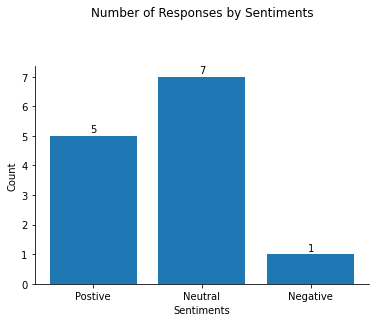

Total Clusters: 6


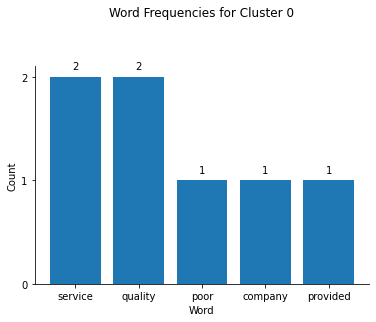

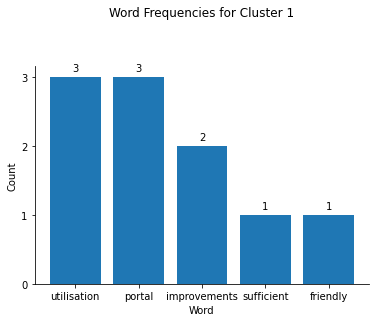

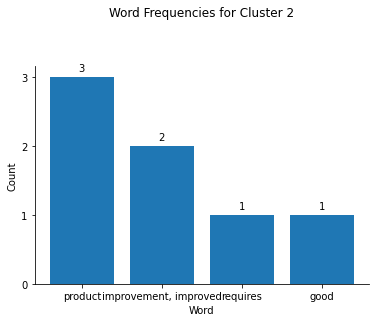

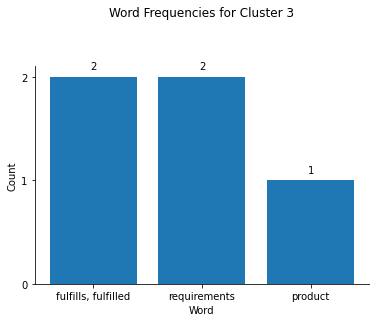

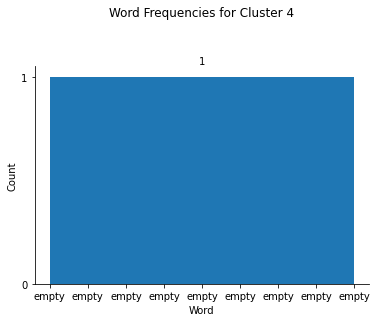

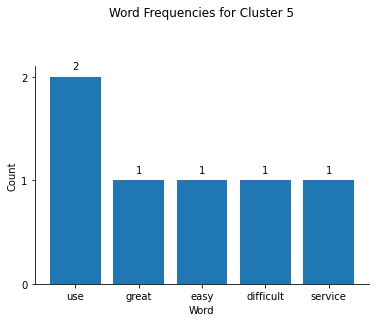

Refer to 'results\2021-05-23_11-10-48\Q3.xlsx' for the processed data.




Min: 1
Max: 8
Total: 49


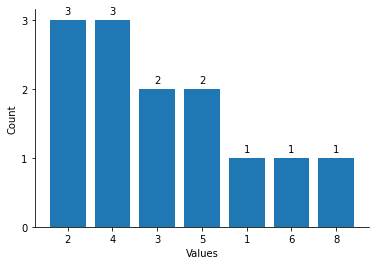

Grand Total of EPV: 42331


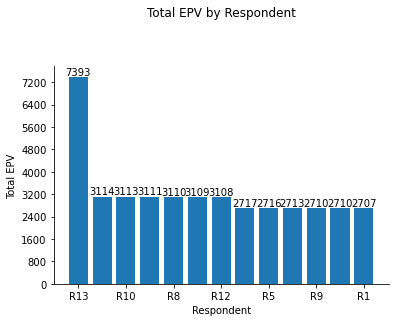

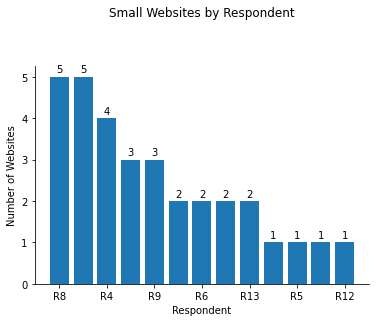

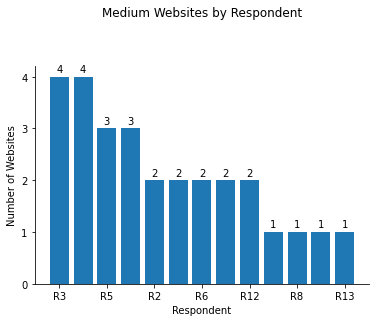

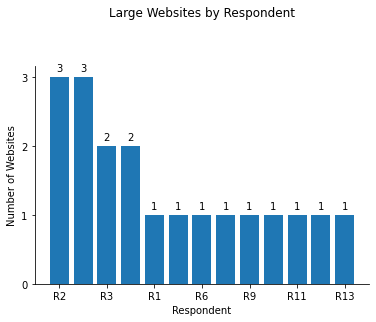

Refer to 'results\2021-05-23_11-10-48\Q5.xlsx' for the processed data.




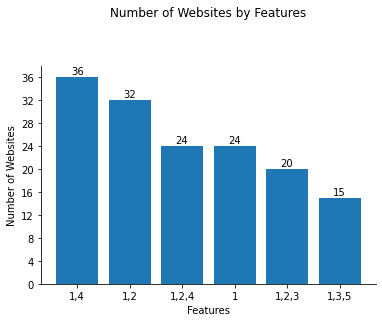

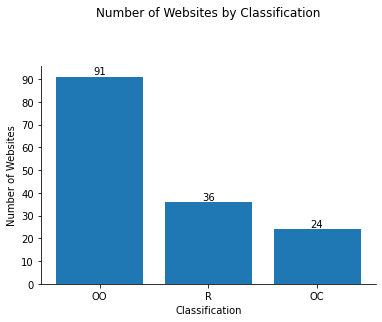

Refer to 'results\2021-05-23_11-10-48\Q6.xlsx' for the processed data.




In [3]:
df = pd.read_excel(open(DATASET,'rb'), sheet_name=DATASET_SHEET, keep_default_na=False)
qd = pd.read_excel(open(QUESTION_DEFINITIONS,'rb'), sheet_name=QUESTION_DEFINITIONS_SHEET, keep_default_na=False)

print("Total Responses: " + str(len(df.index)))
    
question_type_full_name = {
    "sc": "Single Choice",
    "mc": "Multiple Choice",
    "txt": "Free Text",
    "int": "Number",
    "epv": "EPV",
    "wf": "Website Features"
}
question_no = 0
for index, row in qd.iterrows():
    question = row["Question"]
    question_type = row["Type"]
    question_no += 1
    html_print("<h3>[Q" + str(question_no) + "] " + question + "</h3>")
    html_print("<i>" + question_type_full_name[question_type] + "</i>")
    html_print("<hr/>")
    if question_type == "sc":
        df[question] = df[question].replace(r'^\s*$', "(Empty)", regex=True)
        grpby = df.groupby(question)[question].count()
        x,y = zip(*sort_tuples(grpby.items()))
        create_graph(x, y, "", "Values", "Count", "bar")
    elif question_type == "mc":
        df[question] = df[question].replace(r'^\s*$', "(Empty)", regex=True)
        obj = {}
        for row in df[question]:
            selected_options = str(row).split(";")
            for option in selected_options:
                if option not in obj.keys():
                    obj[option] = 1
                else:
                    obj[option] += 1
        x, y = zip(*sort_tuples(obj.items()))
        create_graph(x, y, "", "Values", "Count", "bar")
    elif question_type == "int":
        df[question] = df[question].replace(r'^\s*$', 0, regex=True)
        grpby = df.groupby(question)[question].count()
        print("Min: " + str(df[question].min()))
        print("Max: " + str(df[question].max()))
        print("Total: " + str(df[question].sum()))
        x,y = zip(*sort_tuples(grpby.items()))
        x = list(map(str, x)) # Need to convert all integers to string for the sorting in the graph to work properly
        create_graph(x, y, "", "Values", "Count", "bar")
    elif question_type == "txt":
        sa = SentimentIntensityAnalyzer()
        pos_list = []
        neg_list = []
        neu_list = []
        consolidated_data = {
            "Respondent": [],
            "Text": [],
            "Sentiment": [],
            "Score": [],
        }
        
        # Sentiment Analysis and Sorting of Text
        index = 0
        for row in df[question]:
            consolidated_data["Respondent"].append(df[RESPONDENT][index])
            
            if not row:
                row = "(Empty)"
            
            sa_result = sa.polarity_scores(row)
            pos, neg, neu = itemgetter('pos', 'neg', 'neu')(sa_result)
            consolidated_data["Text"].append(row)
            if pos >= neg + neu:
                pos_list.append(row)
                consolidated_data["Sentiment"].append("Positive")
                consolidated_data["Score"].append(pos)
            elif neg >= pos + neu:
                neg_list.append(row)
                consolidated_data["Sentiment"].append("Negative")
                consolidated_data["Score"].append(neg)
            else:
                neu_list.append(row)
                consolidated_data["Sentiment"].append("Neutral")
                consolidated_data["Score"].append(neu)

            index += 1
        
        x = ["Postive", "Neutral", "Negative"]
        y = [len(pos_list), len(neu_list), len(neg_list)]
        create_graph(x, y, "Number of Responses by Sentiments", "Sentiments", "Count", "bar")
        
        # Highlighting the words with high frequencies
#         pos_wf = word_frequencies(generate_word_list(" ".join(pos_list)))
#         word_frequency_graph(pos_wf, "Word Frequencies - Positive")
#         print("\n")
#         neu_wf = word_frequencies(generate_word_list(" ".join(neu_list)))
#         word_frequency_graph(neu_wf, "Word Frequencies - Neutral")
#         print("\n")
#         neg_wf = word_frequencies(generate_word_list(" ".join(neg_list)))
#         word_frequency_graph(neg_wf, "Word Frequencies - Negative")
        
        # Tag text if they contain words with high frequencies
#         index = -1
#         for row in consolidated_data["Text"]:
#             index += 1
#             if consolidated_data["Sentiment"][index] == "Positive":
#                 wf = pos_wf
#             elif consolidated_data["Sentiment"][index] == "Negative":
#                 wf = neg_wf
#             elif consolidated_data["Sentiment"][index] == "Neutral":
#                 wf = neu_wf
            
#             containWordsWithHighFrequencies = ""
#             text_lowercase = row.lower()
#             for w in wf:
#                 if any(ww in text_lowercase for ww in w[0].split(", ")):
#                     if containWordsWithHighFrequencies != "":
#                         containWordsWithHighFrequencies += ", " + w[0]
#                     else:
#                         containWordsWithHighFrequencies = w[0]
#             if containWordsWithHighFrequencies != "":
#                 consolidated_data["ContainWordsWithHighFrequencies"].append(containWordsWithHighFrequencies)
#             else:
#                 consolidated_data["ContainWordsWithHighFrequencies"].append("-")
        
        # K-Means Clustering
        if len(consolidated_data["Respondent"]) >= 10:
            cluster_list = k_means_clustering(consolidated_data["Respondent"], consolidated_data["Text"])
            respondents, clusters = zip(*cluster_list)
            clusters = list(clusters)
            num_of_clusters = max(clusters) + 1
            text_clusters = list(zip(consolidated_data["Text"], clusters))
            text_clusters = sort_tuples(list(set([(" ".join([t2[0] for t2 in text_clusters if t2[1] == t[1]]), t[1]) for t in text_clusters])), False)
            for t in text_clusters:
                wf = word_frequencies(generate_word_list(t[0]))
                word_frequency_graph(wf, "Word Frequencies for Cluster " + str(t[1]))
            consolidated_data["Clusters"] = clusters
        
        save_to_spreadsheet(consolidated_data, question_no)
        
    elif question_type == "epv":
        fdf = df.filter(like=question)
        d = {"Respondent": [], "Small": [], "Medium": [], "Large": [], "EpvDevelopment": [], "EpvMaintenance": [], "EpvHosting": [], "TotalEpv": []}
        
        for index, row in fdf.iterrows():
            tier_count = {
                "small": 0,
                "medium": 0,
                "large": 0,
                "(empty)": 0
            }
            epvDevelopment = 0
            epvMaintenance = 0
            epvHosting = 0
            for i in range(0,len(fdf.columns)):
                if row[i]:
                    values = row[i].split(";")
                    if not values[0]:
                        values[0] = "(Empty)"
                    for i in range(1,4):
                        if not values[i]:
                            values[i] = 0
                        elif not isinstance(int(values[i].replace("$","").replace(",","")), int):
                            values[i] = 0
                else:
                    values = ["(Empty)","0","0","0"]
                
                tier = values[0].lower()
                if tier in EPV_HOSTING_COST.keys():
                    tier_count[tier] += int(values[1].replace("$","").replace(",",""))
                    epvDevelopment += int(values[2].replace("$","").replace(",",""))
                    epvMaintenance += int(values[3].replace("$","").replace(",",""))
                    epvHosting += int(values[1].replace("$","").replace(",","")) * EPV_HOSTING_COST[tier]
            
            d["Respondent"].append(df[RESPONDENT][index])
            d["Small"].append(tier_count["small"])
            d["Medium"].append(tier_count["medium"])
            d["Large"].append(tier_count["large"])
            d["EpvDevelopment"].append(epvDevelopment)
            d["EpvMaintenance"].append(epvMaintenance)
            d["EpvHosting"].append(epvHosting)
            d["TotalEpv"].append(epvDevelopment + epvMaintenance + epvHosting)
        epv_df = pd.DataFrame(data=d)
        print("Grand Total of EPV: " + str(epv_df["TotalEpv"].sum()))
        x, y = zip(*sort_tuples(zip(d["Respondent"], d["TotalEpv"])))
        create_graph(x, y,"Total EPV by Respondent", "Respondent", "Total EPV", "bar")
        x, y = zip(*sort_tuples(zip(d["Respondent"], d["Small"])))
        create_graph(x, y,"Small Websites by Respondent", "Respondent", "Number of Websites", "bar")
        x, y = zip(*sort_tuples(zip(d["Respondent"], d["Medium"])))
        create_graph(x, y,"Medium Websites by Respondent", "Respondent", "Number of Websites", "bar")
        x, y = zip(*sort_tuples(zip(d["Respondent"], d["Large"])))
        create_graph(x, y,"Large Websites by Respondent", "Respondent", "Number of Websites", "bar")
        
        save_to_spreadsheet(d, question_no)
        
    elif question_type == "wf":
        fdf = df.filter(like=question)
        d = {"Respondent": [], "Features": [], "Classification": [], "NumberOfWebsites": []}
        
        for index, row in fdf.iterrows():
            for i in range(0,len(fdf.columns)):
                d["Respondent"].append(df[RESPONDENT][index])
                if row[i]:
                    values = row[i].split(";")
                    if not values[0]:
                        values[0] = "(Empty)"
                    if not values[1]:
                        values[1] = "(Empty)"
                    if not values[2]:
                        values[2] = "0"
                else:
                    values = ["(Empty)","(Empty)","0"]
                d["Features"].append(values[0].replace(" ", ""))
                d["Classification"].append(values[1].replace(" ", ""))
                d["NumberOfWebsites"].append(int(values[2]))
                
        feature_and_noOfWebsites = list(zip(d["Features"], d["NumberOfWebsites"]))
        feature_and_noOfWebsites = list(set([(f[0], sum(int(g[1]) for g in feature_and_noOfWebsites if g[0] == f[0])) for f in feature_and_noOfWebsites]))
        x, y = zip(*sort_tuples(feature_and_noOfWebsites))
        create_graph(x, y, "Number of Websites by Features", "Features", "Number of Websites", "bar")
        
        classification_and_noOfWebsites = list(zip(d["Classification"], d["NumberOfWebsites"]))
        classification_and_noOfWebsites = list(set([(c[0], sum(int(g[1]) for g in classification_and_noOfWebsites if g[0] == c[0])) for c in classification_and_noOfWebsites]))
        x, y = zip(*sort_tuples(classification_and_noOfWebsites))
        create_graph(x, y, "Number of Websites by Classification", "Classification", "Number of Websites", "bar")
                
        save_to_spreadsheet(d, question_no)
        
    print("\n")